In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Tesi')

In [ ]:
import os
import cv2
import math
import copy
import random
import numpy as np
import pandas as pd
import albumentations as A
from tensorflow import keras
from collections import deque
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import load_model
from tensorflow.keras.utils import Sequence
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

In [ ]:
sequence_length = 8
sequence_stride = 4
batch_size      = 16

# Creation of the model with new temporal length and temporal stride

In [ ]:
from keras import Model
from keras.layers import TimeDistributed, Input

mnv2 = load_model('models/urban/short-range/MobileNetV2/case14/case14_best_model5.h5')

input_layer = Input(shape=(sequence_length, 224, 224, 3))
x = TimeDistributed(mnv2.layers[1].layer)(input_layer)
x = mnv2.layers[2](x)
x = mnv2.layers[3](x)
x = mnv2.layers[4](x)

new_model = Model(inputs=input_layer, outputs=x)
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8, 224, 224, 3)]  0         
                                                                 
 time_distributed_1 (TimeDis  (None, 8, 1280)          2257984   
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 100)               552400    
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2,810,485
Trainable params: 2,776,373
Non-trainable params: 34,112
____________________________________________

# Train the model with new temporal length and temporal stride

In [ ]:
def file_generator(data_path, data_files, temporal_stride, temporal_length):
  '''
  data_files - list of csv files to be read
  '''
  for f in data_files:
    tmp_df = pd.read_csv(os.path.join(data_path, f))
    total_images = len(tmp_df)
    if total_images >= temporal_length:
      num_samples = int((total_images - temporal_length)/temporal_stride) + 1
      # print('num of samples from vid seq-{}: {}'.format(f, num_samples))
    else:
      # print('num of frames is less than temporal length; hence discarding this \
      #       file-{}'.format(f))
      continue

    samples = deque()
    labels = deque()

    for index, row in tmp_df.iterrows():
      samples.append('/content/drive/My Drive' + row['filename'][30:])
      labels.append(int(row['Flames']))
      if len(samples) == temporal_length:
        to_delete = False
        if labels.count(labels[0]) != len(labels):
          to_delete = True
        samples_c = copy.deepcopy(samples)
        for t in range(temporal_stride):
          samples.popleft()
          labels.popleft()
        if to_delete: continue
        yield samples_c, labels[0]

def load_samples(CSV_folder, temporal_stride, temporal_length):
  data_path = os.path.join('csv', CSV_folder)
  data_files = os.listdir(data_path)
  file_gen = file_generator(data_path, data_files, temporal_stride, temporal_length)
  iterator = True
  data_list = []

  while iterator:
    try:
      x, y = next(file_gen)
      x = list(x)
      data_list.append([x, y])
    except Exception as e:
      # print('Exception: ', e)
      iterator = False
      # print('end of data generator ')
  return data_list

def to_weight(train_data):
  # putting generated labels into a list
  training_labels = []
  for sample in range(len(train_data)):
    training_labels.append(train_data[sample][1])

  weights_sklearn = compute_class_weight(class_weight='balanced', 
                                        classes=np.unique(np.array(training_labels)),
                                        y=np.array(training_labels))
  weights = {0: weights_sklearn[0], 1: weights_sklearn[1]}
  return weights

class DataGenerator(Sequence):

    def __init__(self, data, batch_size, shuffle_data, aug):
        self.num_samples = len(data)
        self.data = shuffle(data) if shuffle_data else data
        self.batch_size = batch_size
        self.aug = aug        
        self.additional_targets = {[f'image{i}' for i in range(sequence_length-1)][j]:'image' for j in range(sequence_length-1)}

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, idx):
        #print('starting index: ', idx * self.batch_size)
        batch_samples = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_train = []
        y_train = []
        for batch_sample in batch_samples:
            x = batch_sample[0]   # Load image (X)
            y = batch_sample[1]   # Read label (y)
            temp_data_list = []
            for img_name in x:
                try:
                    img = cv2.imread(img_name)
                    img = cv2.resize(img, (224,224))
                    temp_data_list.append(img[:,:, ::-1])
                except Exception as e:
                    print(e)
                    print('error reading file: ', img_name)
            if self.aug:
                temp_data_list = self.__totransform__(temp_data_list)
            # Add example to arrays
            X_train.append(temp_data_list)
            y_train.append(y)
        # Make sure they're numpy arrays (as opposed to lists)
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        return X_train, y_train
   
    def __totransform__(self, list_of_frames):

        transform = A.Compose([   
            A.HorizontalFlip(p=0.5),
            A.OneOf(
              [
                A.Blur(p=0.01, blur_limit=(3, 7)),
                A.MedianBlur(p=0.01, blur_limit=(3, 7)),
                A.MotionBlur(p=0.01, blur_limit=(3, 7)),
                A.GaussianBlur(p=0.01, blur_limit=(3, 7), sigma_limit=(0.0, 0)),
                #A.ZoomBlur(p=0.01, max_factor=(1.0, 1.12), step_factor=(0.01, 0.03)),
                #A.Defocus(p=0.01, radius=(1, 4), alias_blur=(0.1, 0.5)),
                A.RingingOvershoot(p=0.01, blur_limit=(7, 15), cutoff=(0.7, 1.57)),
                A.Downscale(p=0.01, scale_min=0.8, scale_max=0.99),
                A.ImageCompression(p=0.01, quality_lower=80, quality_upper=100,
                                    compression_type=0),
                A.JpegCompression(p=0.01, quality_lower=80, quality_upper=100),
                A.GaussNoise(p=0.01, var_limit=(10, 50), per_channel=True, mean=0.0),
                A.MultiplicativeNoise(p=0.01, multiplier=(0.9, 1.1), 
                                        per_channel=True, elementwise=True),
                # A.CLAHE(p=0.01, clip_limit=(1,4), tile_grid_size=(8, 8)),
                # A.Sharpen(p=0.01, alpha=(0.2, 0.5), lightness=(0.5, 1.0)),
                # A.UnsharpMask(p=0.01, blur_limit=(3, 7), sigma_limit=(0.0, 0.0),
                #                 alpha=(0.2, 0.5), threshold=10),
                # A.Emboss(p=0.01, alpha=(0.2, 0.5), strength=(0.2, 0.7)),
                # A.RandomBrightness(p=0.01, limit=(-0.2, 0.2)),
                # A.RandomContrast(p=0.01, limit=(-0.2, 0.2)),
                # A.RandomBrightnessContrast(p=0.01, brightness_limit=(-0.2, 0.2),
                #                             contrast_limit=(-0.2, 0.2), 
                #                             brightness_by_max=True),
                # A.ISONoise(p=0.01, intensity=(0.1, 0.5), color_shift=(0.01, 0.05)),
                # A.Equalize(p=0.01, mode='cv', by_channels=False),             
                # A.FancyPCA(p=0.01, alpha=0.1),
                # A.RGBShift(p=0.01, r_shift_limit=(-20, 20), 
                #             g_shift_limit=(-20, 20), b_shift_limit=(-20, 20)),
                # A.RandomGamma(p=0.01, gamma_limit=(80, 120), eps=None),
                # A.RandomToneCurve(p=0.01, scale=0.1),
                # A.SafeRotate(p=0.01, limit=(-90, 90), interpolation=0, 
                #               border_mode=0, value=(0, 0, 0), mask_value=None),
                # A.OpticalDistortion(p=0.01, distort_limit=(-0.3, 0.3),
                #                       shift_limit=(-0.05, 0.05), interpolation=0,
                #                       border_mode=0, value=(0, 0, 0), mask_value=None),
                # A.GridDistortion(p=0.01, num_steps=5, distort_limit=(-0.3, 0.3),
                #                   interpolation=0, border_mode=0, value=(0, 0, 0),
                #                   mask_value=None, normalized=False),
                # A.Perspective(p=0.01, scale=(0.05, 0.1), keep_size=0, pad_mode=0,
                #                 pad_val=(0, 0, 0), mask_pad_val=0, fit_output=0, 
                #                 interpolation=0),
                # A.PiecewiseAffine(p=0.01, scale=(0.03, 0.05), nb_rows=(4, 4), 
                #                     nb_cols=(4, 4), interpolation=0,
                #                     mask_interpolation=0, cval=0, cval_mask=0,
                #                     mode='constant', absolute_scale=0, 
                #                     keypoints_threshold=0.01),
                # A.RandomCropFromBorders(p=0.01, crop_left=0.1, crop_right=0.1, 
                #                           crop_top=0.1, crop_bottom=0.1),
                # A.CoarseDropout(p=0.01, max_holes=8, max_height=8, max_width=8, 
                #                   min_holes=8, min_height=8, min_width=8, 
                #                   fill_value=(0, 0, 0), mask_fill_value=None),
                # A.PixelDropout(p=0.01, dropout_prob=0.01, per_channel=0, 
                #                 drop_value=(0, 0, 0), mask_drop_value=None),
                # A.RandomFog(p=0.01, fog_coef_lower=0.2, fog_coef_upper=0.2, 
                #               alpha_coef=0.08),
                # A.RandomSnow(p=0.01, snow_point_lower=0.1, snow_point_upper=0.1, 
                #               brightness_coeff=2),
                # A.RandomRain(p=0.01, slant_lower=-10, slant_upper=10, 
                #               drop_length=20, drop_width=1, drop_color=(0, 0, 0),
                #               blur_value=3, brightness_coefficient=0.7, rain_type=None),
                # A.Spatter(p=0.01, mean=(0.65, 0.65), std=(0.3, 0.3), 
                #             gauss_sigma=(2.0, 2.0), intensity=(0.6, 0.6), 
                #             cutout_threshold=(0.68, 0.68), mode=['rain']),
                # A.Spatter(p=0.01, mean=(0.65, 0.65), std=(0.3, 0.3), 
                #             gauss_sigma=(2.0, 2.0), intensity=(0.6, 0.6), 
                #             cutout_threshold=(0.68, 0.68), mode=['mud']),
              ], p=0.8),
        ], additional_targets=self.additional_targets)

        transformed = transform(image=list_of_frames[0], 
                                image0=list_of_frames[1], 
                                image1=list_of_frames[2],
                                image2=list_of_frames[3],
                                image3=list_of_frames[4],
                                image4=list_of_frames[5],
                                image5=list_of_frames[6],
                                image6=list_of_frames[7]  )
        
        return  [   cv2.resize(transformed['image'], (224,224)),
                    cv2.resize(transformed['image0'], (224,224)),
                    cv2.resize(transformed['image1'], (224,224)),
                    cv2.resize(transformed['image2'], (224,224)),
                    cv2.resize(transformed['image3'], (224,224)),
                    cv2.resize(transformed['image4'], (224,224)),
                    cv2.resize(transformed['image5'], (224,224)),
                    cv2.resize(transformed['image6'], (224,224))   ]

fit_results = []
evaluate_results = []

for count in range(1, 6):
    train_data = load_samples(CSV_folder='Train/urban/KFold_short-range/fold'\
                                + str(count), temporal_stride=sequence_stride,
                            temporal_length=sequence_length)
    test_data = load_samples(CSV_folder='Test/urban/KFold_short-range/fold'\
                            + str(count), temporal_stride=sequence_stride,
                            temporal_length=sequence_length)
    val_data = load_samples(CSV_folder='Validation/urban/KFold_short-range/fold'\
                           + str(count), temporal_stride=sequence_stride,
                          temporal_length=sequence_length)
    
    weights = to_weight(train_data)

    train_gen = DataGenerator(data=train_data, batch_size=batch_size, 
                                shuffle_data=True, aug=True)
    test_gen = DataGenerator(data=test_data, batch_size=batch_size, 
                            shuffle_data=False, aug=False)
    val_gen = DataGenerator(data=val_data, batch_size=batch_size, 
                            shuffle_data=True, aug=False)

    model = new_model
    model.compile(loss='binary_crossentropy',
                    optimizer=Adam(0.000001), metrics=['accuracy'])
    
    cs = 'case14_seq8'
    
    my_callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5,
                                    mode='auto', restore_best_weights=True),
        keras.callbacks.ModelCheckpoint(
            'models/urban/short-range/MobileNetV2/new_sequence_lengths/8temporal_length_4temporalstride/' + cs + '_best_model' + str(count) + '.h5',
            monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        keras.callbacks.TensorBoard(log_dir='models/urban/short-range/MobileNetV2/new_sequence_lengths/8temporal_length_4temporalstride/' + cs + '_tensorboard' + str(count)),
        keras.callbacks.CSVLogger(
            'models/urban/short-range/MobileNetV2/new_sequence_lengths/8temporal_length_4temporalstride/' + cs + '_epochs_results' + str(count) + '.csv',
            separator=",", append=False),
    ]

    print("\n\n" + cs + " - STARTING FIT " + str(count) + " ...\n\n")

    model.fit(train_gen, epochs=50, validation_data=val_gen, callbacks=my_callbacks,
            class_weight=weights, use_multiprocessing=True, workers=4)

# Evaluate the model with new temporal length and temporal stride

In [ ]:
class DataGenerator(Sequence):

    def __init__(self, data, batch_size, shuffle_data, aug):
        self.num_samples = len(data)
        self.data = shuffle(data) if shuffle_data else data
        self.batch_size = batch_size
        self.aug = aug        
        self.additional_targets = {[f'image{i}' for i in range(sequence_length-1)][j]:'image' for j in range(sequence_length-1)}

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, idx):
        #print('starting index: ', idx * self.batch_size)
        batch_samples = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_train = []
        y_train = []
        for batch_sample in batch_samples:
            x = batch_sample[0]   # Load image (X)
            y = batch_sample[1]   # Read label (y)
            temp_data_list = []
            for img_name in x:
                try:
                    img = cv2.imread(img_name)
                    img = cv2.resize(img, (224,224))
                    temp_data_list.append(img[:,:, ::-1])
                except Exception as e:
                    print(e)
                    print('error reading file: ', img_name)
            # if self.aug:
            #     temp_data_list = self.__totransform__(temp_data_list)
            # Add example to arrays
            X_train.append(temp_data_list)
            y_train.append(y)
        # Make sure they're numpy arrays (as opposed to lists)
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        return X_train, y_train

In [ ]:
def file_generator(data_path, data_files, temporal_stride, temporal_length):
  '''
  data_files - list of csv files to be read
  '''
  for f in data_files:
    tmp_df = pd.read_csv(os.path.join(data_path, f))
    total_images = len(tmp_df)
    if total_images >= temporal_length:
      num_samples = int((total_images - temporal_length)/temporal_stride) + 1
      #print('num of samples from vid seq-{}: {}'.format(f, num_samples))
    else:
      #print('num of frames is less than temporal length; hence discarding this \
      #      file-{}'.format(f))
      continue

    samples = deque()
    labels = deque()

    for index, row in tmp_df.iterrows():
      samples.append('/content/drive/My Drive' + row['filename'][30:])
      labels.append(int(row['Flames']))
      if len(samples) == temporal_length:
        to_delete = False
        if labels.count(labels[0]) != len(labels):
          to_delete = True
        samples_c = copy.deepcopy(samples)
        for t in range(temporal_stride):
          samples.popleft()
          labels.popleft()
        if to_delete: continue
        yield samples_c, labels[0]

def load_samples(CSV_folder, temporal_stride, temporal_length):
  data_path = os.path.join('csv', CSV_folder)
  data_files = os.listdir(data_path)
  file_gen = file_generator(data_path, data_files, temporal_stride, temporal_length)
  iterator = True
  data_list = []

  while iterator:
    try:
      x, y = next(file_gen)
      x = list(x)
      data_list.append([x, y])
    except Exception as e:
      #print('Exception: ', e)
      iterator = False
      #print('end of data generator ')
  return data_list

test_data = load_samples(CSV_folder='Test/urban/KFold_short-range/fold5', 
                            temporal_stride=sequence_stride,
                            temporal_length=sequence_length)

test_gen = DataGenerator(data=test_data, batch_size=batch_size, 
                         shuffle_data=False, aug=False)

36/36 [==============================] - 283s 8s/step


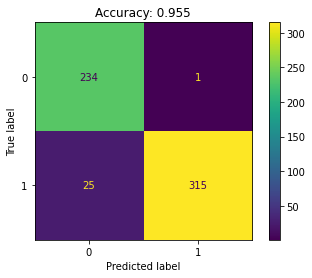

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_cm(y, pred):
  p = []
  for i in pred:
    p.append(round(list(i)[0]))
  p = np.array(p)
  y = np.array(y)
  cm = confusion_matrix(y, p)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.title('Accuracy: %.3f' % (y==p).mean())
  plt.show()

model = load_model('models/urban/short-range/MobileNetV2/new_sequence_lengths/8temporal_length_4temporalstride/case14_seq8_best_model5.h5')

test_labels = []
for test in range(len(test_data)):
  test_labels.append(test_data[test][1])

pred = model.predict(test_gen)
plot_cm(y=test_labels, pred=list(pred))